In [1]:
# Code Information
# Paper https://hal.archives-ouvertes.fr/hal-03261428
# This code partially based on the DJOT paper. Some functions where reused or re-implemented.
# if you use this code, both our paper and their paper should be cited.

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
from PIL import Image
import numpy as np
import glob
import cv2
import os
from os.path import join
import random
#from medpy.io import load
#from medpy import metric

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['image.cmap'] = 'gist_gray'

In [5]:
from __future__ import print_function, division, absolute_import, unicode_literals

In [6]:
import sys
sys.path.insert(1, '/tf/2021Work/WSC/')

# Data Handler

In [7]:
data_path_mri = '/tf/2021Work/WSC/DataWSPickle/MRI/'
data_path_ct = '/tf/2021Work/WSC/DataWSPickle/CT/'

In [8]:
raw_size = [256, 256, 1] #
volume_size = [256, 256, 1]
label_size = [256, 256, 1] 

# Data Handler using Pickle Files instead of TFrecords

In [9]:
import pickle

# TF Model

In [10]:
import tensorflow as tf

In [11]:
import os
import sys
import random
import warnings
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [12]:
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
from skimage.io import imread, imshow

# Model

In [13]:
# Set some parameters
IMG_HEIGHT=256
IMG_WIDTH =256
IMG_CHANNELS=1
num_classes =1


INPUT_DIM = (256,256,3) # Image dimension
BATCH_SIZE = 128
Z_DIM = 1024 # Dimension of the latent vector (z)


In [14]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

In [15]:
# ENCODER
batch_size=128
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  global K
  K.clear_session()
  n_layers = len(conv_filters)
  encoder_input = Input(shape = input_dim, batch_size=None, name = 'encoder_input')
  x = encoder_input
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten(name = 'DeepFeatures')(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])
  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [16]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

W0301 12:22:57.057152 140428040808256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
vae_encoder_input

<tf.Tensor 'encoder_input:0' shape=(?, 256, 256, 3) dtype=float32>

In [18]:
vae_encoder_output

<tf.Tensor 'encoder_output/add:0' shape=(?, 1024) dtype=float32>

In [19]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):
  n_layers = len(conv_filters)
  decoder_input = Input(shape = (input_dim,) , batch_size=None, name = 'decoder_input')
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)
  decoder_output = x
  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [20]:
vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = vae_shape_before_flattening,
                                        conv_filters = [64,64,32,4],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

In [21]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Data preperation

In [22]:
X_train = []
Y_train = []
X_val = []
Y_val = []
for i in range(96):
    with open(data_path_mri+'x_mri_t_'+str(i)+'.pickle', 'rb') as handle:
        x_mri_t = pickle.load(handle)  
        X_train.extend(x_mri_t[:,:,:,:])
    with open(data_path_mri+'y_mri_t_'+str(i)+'.pickle', 'rb') as handle:
        y_mri_t = pickle.load(handle)      
        Y_train.extend(y_mri_t[:,:,:,1:])
    with open(data_path_mri+'x_mri_v_'+str(i)+'.pickle', 'rb') as handle:
        x_mri_v = pickle.load(handle)      
        X_val.extend(x_mri_v[:,:,:,:])
    with open(data_path_mri+'y_mri_v_'+str(i)+'.pickle', 'rb') as handle:
        y_mri_v = pickle.load(handle)  
        Y_val.extend(y_mri_v[:,:,:,1:])

In [23]:
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [24]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(6098, 256, 256, 3)
(6098, 256, 256, 4)
(6080, 256, 256, 3)
(6080, 256, 256, 4)


In [25]:
data_path_ct = '/tf/2021Work/WSC/DataWSPickle/CT/'
X_test = []
Y_test = []

for i in range(96):
    with open(data_path_ct+'x_ct_t_'+str(i)+'.pickle', 'rb') as handle:
        x_ct_t = pickle.load(handle)  
        X_test.extend(x_ct_t[:,:,:,:])
    with open(data_path_ct+'y_ct_t_'+str(i)+'.pickle', 'rb') as handle:
        y_ct_t = pickle.load(handle)      
        Y_test.extend(y_ct_t[:,:,:,1:])
X_test = np.array(X_test)
Y_test = np.array(Y_test)


In [26]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(6098, 256, 256, 3)
(6098, 256, 256, 4)
(6080, 256, 256, 3)
(6080, 256, 256, 4)
(4909, 256, 256, 3)
(4909, 256, 256, 4)


In [27]:
X_train =  np.concatenate([X_train,X_val],0)
Y_train =  np.concatenate([Y_train,Y_val],0)

# Model

In [28]:
target_model = Model(inputs=[vae_input], outputs=[vae_output,vae_encoder_output])

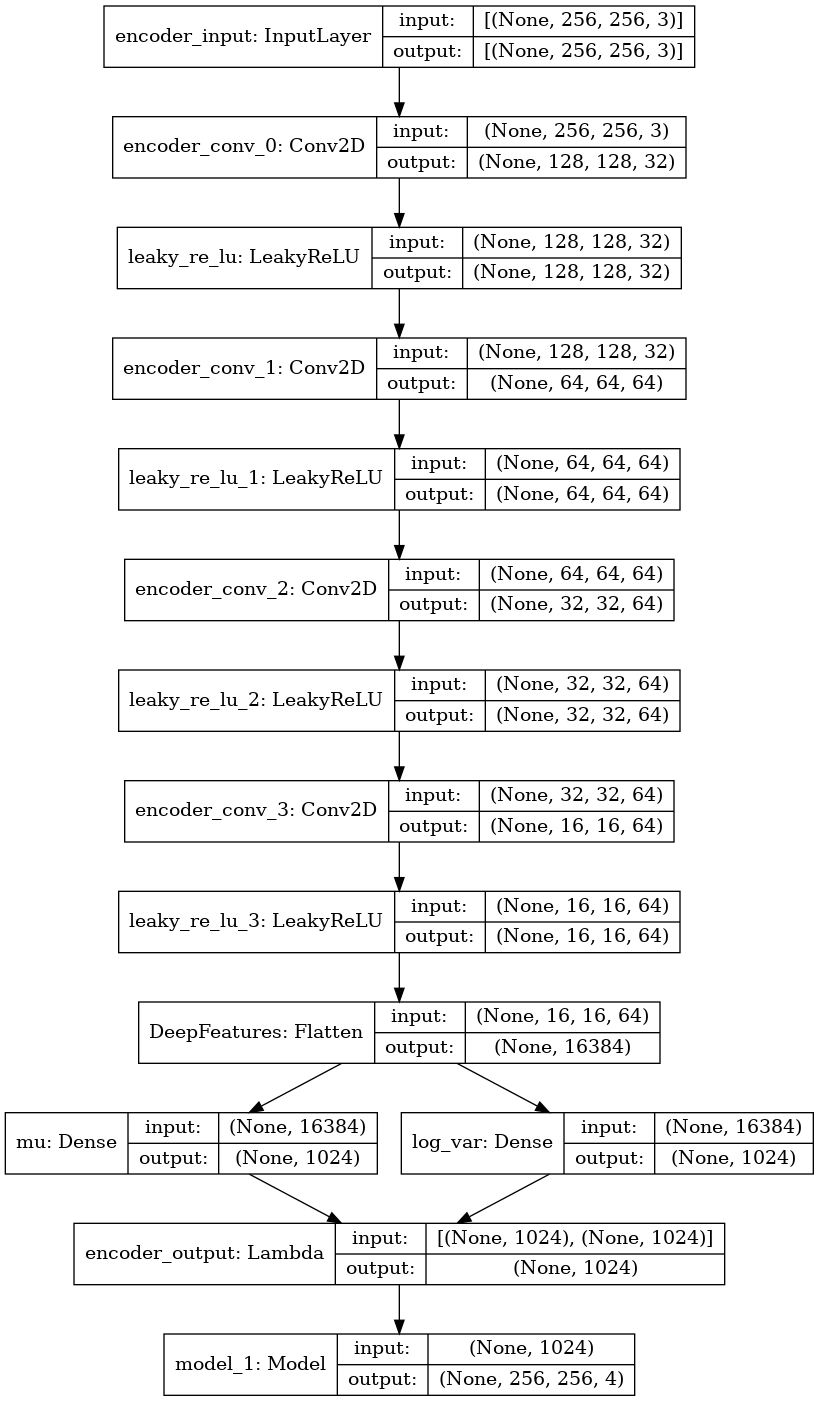

In [29]:
plot_model(target_model, to_file='target_model.png', show_shapes=True, show_layer_names=True)

# Seg-VAEOT

In [30]:
import numpy as np
import ot
from scipy.spatial.distance import cdist 

In [31]:
sample_size=50
batch_size=128

#  weight for source classification and target classification 
sloss=sloss = 2.0
tloss=tloss=1.0
# learning rate
int_lr=int_lr=0.0001
lr_decay=True
# OT method
ot_method='emd'
# whether to minimize with classification loss and the allignment loss 
tar_cl_loss=1.0
allign_loss=1.0
# weight for the alpha term
jdot_alpha=jdot_alpha=1.0

In [32]:
# initialize the gamma (coupling in OT) with zeros
batch_size_half=int(batch_size/2)
gamma_W= K.zeros(shape=(batch_size_half,batch_size_half))
print(gamma_W)

<tf.Variable 'Variable:0' shape=(64, 64) dtype=float32>


In [33]:
# whether to minimize with classification loss
train_cl =K.variable(tar_cl_loss)
print(train_cl)

<tf.Variable 'Variable_1:0' shape=() dtype=float32>


In [34]:
# whether to minimize with the allignment loss 
train_algn=K.variable(allign_loss)
train_algn

<tf.Variable 'Variable_2:0' shape=() dtype=float32>

In [35]:
W_sloss = K.variable(sloss) # weight for source classification
W_tloss = K.variable(tloss) # weight for target classification

In [36]:
# L2 distance
def L2_dist(x,y):
    '''
    compute the squared L2 distance between two matrics
    '''
    dist = K.reshape(K.sum(K.square(x),1), (-1,1))
    dist += K.reshape(K.sum(K.square(y),1), (1,-1))
    dist -= 2.0*K.dot(x, K.transpose(y))  
    return dist

In [37]:
# feature allignment loss
def align_loss(y_true, y_pred):
    '''
    source and target alignment loss in the intermediate layers of the target model
    allignment is performed in the target model (both source and target features are from target model)
    y-true - is dummy value( that is full of zeros)
    y-pred - is the value of intermediate layers in the target model
    1:batch_size - is source samples
    batch_size:end - is target samples  
    batch_size = 32
    '''
    batch_size_half=int(batch_size/2)
    # source domain features            
    gs = vae_encoder_output[:batch_size_half,:]
    #gs = tf.reshape(gs,[-1,vae_encoder_output.shape[1]])
    # target domain features
    gt = vae_encoder_output[batch_size_half:,:]
    #gt = tf.reshape(gt,[-1,AVG.shape[1]])
    gdist = L2_dist(gs,gt)  
    return 10 * K.sum(gamma_W * (gdist))

In [38]:
# We dont use it as it does not bring any additional advantage than increasing the complexity
def PredictionMapAlignment(y_true, y_pred):
    a = K.reshape(K.sum(K.square(y_true[:64]),axis = [1,2,3]), (-1,1))
    b= K.reshape(K.sum(K.square(y_pred[64:]),axis = [1,2,3]), (1,-1))
    dist = K.sqrt(a + b - 2.0*K.dot(a, b))
    return K.sum(gamma_W * (dist))

In [39]:
ns = X_train.shape[0]
nt= X_test.shape[0]
method=ot_method # for optimal transport
alpha=jdot_alpha = 1.0
fe_size =vae_encoder_output.shape[1]
t_acc = []
t_loss =[]
tloss = K.eval(W_tloss)
g_metric ='deep'

In [40]:
# to 64 its the batch of the Source data that we know its ground Truth
def r_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true[:64] - y_pred[:64]), axis = [1,2,3]))


#here we consider the 128 batch, the 64 from the source and the 64 from the target domain
def kl_loss(y_true, y_pred):
    kl_loss =  K.mean(-0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1))
    return kl_loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


# to 64 its the batch of the Source data that we know its ground Truth
def CE_loss1(y_true, y_pred):
    return dice_loss(y_true[:64,:,:,:1],y_pred[:64,:,:,:1])

def CE_loss2(y_true, y_pred):
    return dice_loss(y_true[:64,:,:,1:2],y_pred[:64,:,:,1:2])

def CE_loss3(y_true, y_pred):
    return dice_loss(y_true[:64,:,:,2:3],y_pred[:64,:,:,2:3])

def CE_loss4(y_true, y_pred):
    return dice_loss(y_true[:64,:,:,3:],y_pred[:64,:,:,3:])


In [41]:
def Model_loss(y_true, y_pred):
    return CE_loss1(y_true, y_pred)  + CE_loss2(y_true, y_pred) + \
     CE_loss3(y_true, y_pred) + CE_loss4(y_true, y_pred) +r_loss(y_true, y_pred) + 0.1*kl_loss(y_true, y_pred)

In [42]:
losses={'model_1': Model_loss, 
        'encoder_output': align_loss}

In [43]:
metrics_display={'model_1': Model_loss, 
                 'encoder_output': align_loss}

In [44]:
# target model compliation and optimizer
target_model.compile(optimizer='adam', loss =losses) #,metrics=metrics_display)

In [45]:
# set the learning rate
K.set_value(target_model.optimizer.lr, int_lr) 

In [46]:
from medpy import metric

In [47]:
def predictTarget(data):
    ypred = target_model.predict(data)
    return ypred

def evaluateTarget(data, label):
    ypred = target_model.predict(data)[0]
    ypred = (ypred > 0.5).astype(np.uint8)
    score = metric.binary.dc(ypred,label)
    return score

In [48]:
import random
batch_size_half= 64
indicies = random.sample(range(1, X_test.shape[0]), batch_size_half)

In [49]:
X_train[indicies].shape

(64, 256, 256, 3)

In [50]:
Y_train.shape
int_lr=0.0001
lr = K.get_value(target_model.optimizer.lr)

In [ ]:
losses={'model_1': Model_loss, 
        'encoder_output': align_loss}

# Load the model back

In [62]:
#target_model = load_model('/tf/2021Work/WSC/TargetModelBestVersion.h5',compile=False)

In [51]:
modelpath = '/tf/2021Work/WSC/TargetModelBestVersion.h5'
target_model = load_model(modelpath, custom_objects={'Model_loss': Model_loss, 'align_loss': align_loss})

W0301 12:25:08.870726 140428040808256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0301 12:25:08.872424 140428040808256 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [52]:
#TODO
'''
Slicing None Tensor in Keras produce error. To avoid this problem, we fix the batch size, a dynamic slicing should solve this problem.
'''

'\nSlicing None Tensor in Keras produce error. To avoid this problem, we fix the batch size, a dynamic slicing should solve this problem.\n'

# Evaluation over the Test Data

In [53]:
X_test.shape

(4909, 256, 256, 3)

In [54]:
preds_test =  target_model.predict(X_test)[0]
preds_test = (preds_test > 0.5).astype(np.uint8)

In [55]:
# Threshold predictions
print('Dice Test',metric.binary.dc(preds_test,Y_test))

Dice Test 0.9646659732372473


In [58]:
# Threshold predictions
print('IoU Test',metric.binary.jc(preds_test,Y_test))
print('Dice Test',metric.binary.dc(preds_test,Y_test))
print('HD Test',metric.binary.hd(preds_test,Y_test))
print('ASD Test',metric.binary.asd(preds_test,Y_test))
print('P Test',metric.binary.precision(preds_test,Y_test))
print('R Test',metric.binary.recall(preds_test,Y_test))


IoU Test 0.9319332153294472
Dice Test 0.9647675270912791
HD Test 22.20360331117452
ASD Test 0.04253043303197384
P Test 0.963729267557308
R Test 0.9658080261452018


In [54]:
preds_test =  target_model.predict(X_test[2909:])[0]
preds_test = (preds_test > 0.5).astype(np.uint8)

In [55]:
# Threshold predictions
print('IoU Test',metric.binary.jc(preds_test,Y_test[2909:]))
print('Dice Test',metric.binary.dc(preds_test,Y_test[2909:]))
print('HD Test',metric.binary.hd(preds_test,Y_test[2909:]))
print('ASSD Test',metric.binary.assd(preds_test,Y_test[2909:]))
print('P Test',metric.binary.precision(preds_test,Y_test[2909:]))
print('R Test',metric.binary.recall(preds_test,Y_test[2909:]))


IoU Test 0.9307880817907451
Dice Test 0.9641535397581992
HD Test 21.18962010041709
ASSD Test 0.04465887364801567
P Test 0.9632042519507436
R Test 0.9651047005564419


In [56]:
print('Dice 1',metric.binary.dc(preds_test[...,:1],Y_test[2909:][...,:1]))
print('Dice 2',metric.binary.dc(preds_test[...,1:2],Y_test[2909:][...,1:2]))
print('Dice 3',metric.binary.dc(preds_test[...,2:3],Y_test[2909:][...,2:3]))
print('Dice 4',metric.binary.dc(preds_test[...,3:],Y_test[2909:][...,3:]))

Dice 1 0.9473593841899436
Dice 2 0.9720802483475306
Dice 3 0.9748925748477996
Dice 4 0.967568103508511


In [57]:
print('ASSD 1',metric.binary.assd(preds_test[...,:1],Y_test[2909:][...,:1]))
print('ASSD 2',metric.binary.assd(preds_test[...,1:2],Y_test[2909:][...,1:2]))
print('ASSD 3',metric.binary.assd(preds_test[...,2:3],Y_test[2909:][...,2:3]))
print('ASSD 4',metric.binary.assd(preds_test[...,3:],Y_test[2909:][...,3:]))

ASSD 1 0.06558385349616357
ASSD 2 0.04229242029025061
ASSD 3 0.03234906432340229
ASSD 4 0.05600279699321529


In [ ]:
# Plot

In [58]:
save_path = '/tf/2021Work/WSC/FiguresPaper/Oracle/'

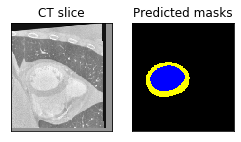

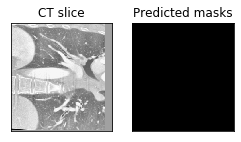

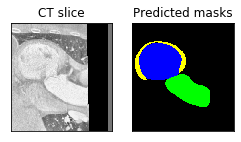

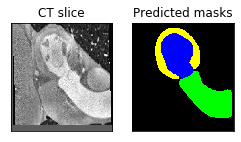

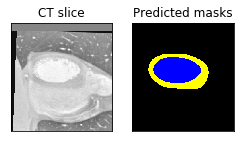

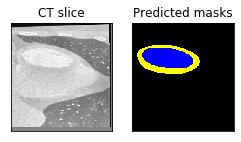

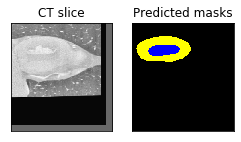

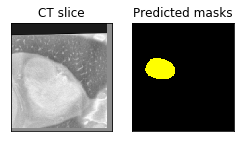

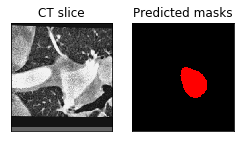

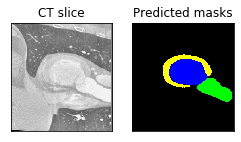

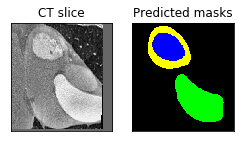

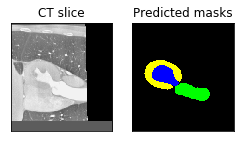

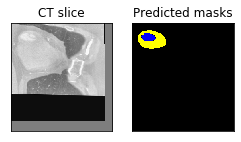

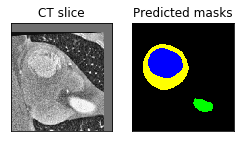

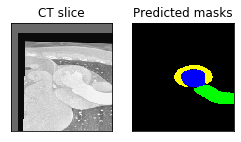

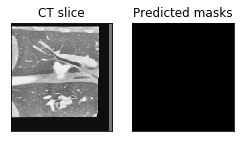

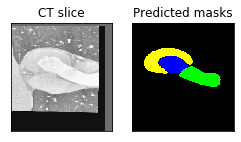

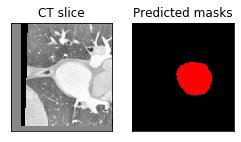

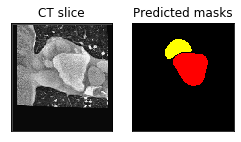

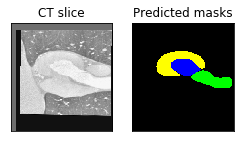

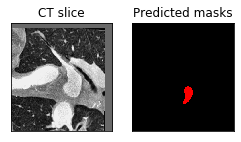

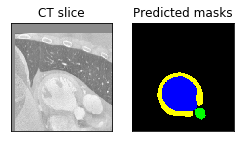

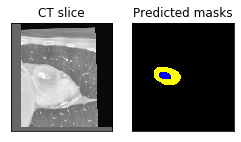

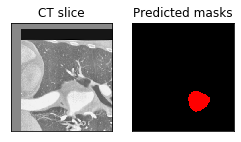

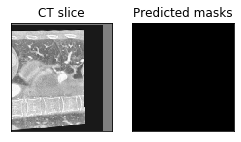

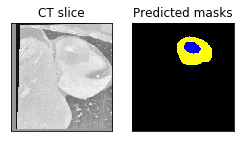

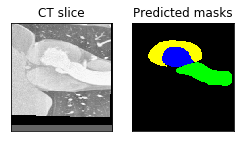

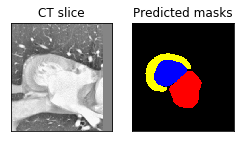

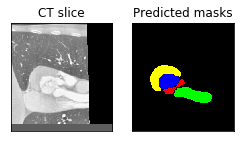

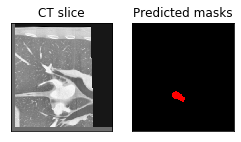

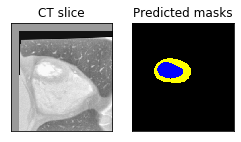

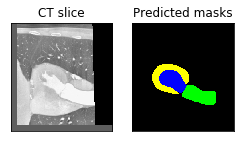

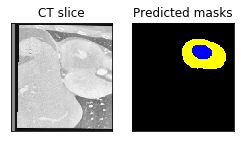

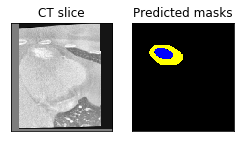

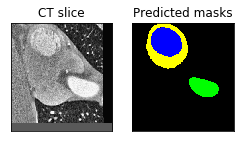

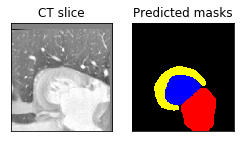

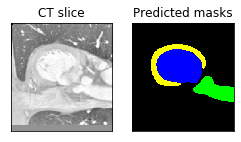

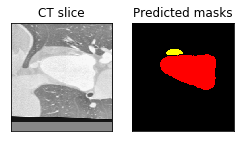

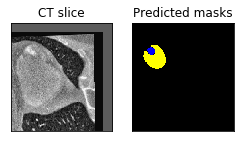

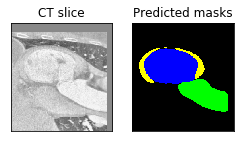

In [59]:
for i in range(0,40):
    index = i
    img = X_test[2909:][index][:,:,0]
    edges1 = preds_test[index][:,:,0]  
    edges2 = preds_test[index][:,:,1]  
    edges3 = preds_test[index][:,:,2]  
    edges4 = preds_test[index][:,:,3] 
    
    img = cv2.merge((edges1,edges1,edges1))    
    img[edges1 == 1] = [255,255,0]  # Circle edges Yellow        LV-M
    img[edges2 == 1] = [255,0,0]  # red                          LA-B
    img[edges3 == 1] = [0,0,255]  #  Circle inside Pink       LV-B
    img[edges4 == 1] = [0,255,0]  #  Green                        A-A

    # Plot each muscle alone aalongside the 2d slice
    fig, ax = plt.subplots(1,2, sharey=True, figsize=(4,2))

    ax[0].imshow(X_test[2909:][index][:,:,0], aspect="auto",cmap='gray')
    ax[1].imshow(img, aspect="auto",cmap='gray')

    ax[0].set_title('CT slice')
    ax[1].set_title('Predicted masks')

    # Remove the x and y labels
    ax[0].axes.get_xaxis().set_ticks([])
    ax[0].axes.get_yaxis().set_ticks([])
    ax[1].axes.get_xaxis().set_ticks([])
    ax[1].axes.get_yaxis().set_ticks([])

    # # save the figure
    fig = plt.gcf()
    fig.savefig(save_path+ str(index) + 'prediction_oracle.png', dpi=300,bbox_inches ='tight')    
    plt.show()

In [59]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch

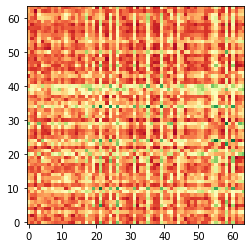

In [63]:
fig, ax = plt.subplots()
im = ax.imshow(C0, cmap=cm.RdYlGn,
               origin='lower')
plt.show()

# or we can access it through al_model.gamma.numpy()

In [64]:
C0[0][0]

11.467536960960143

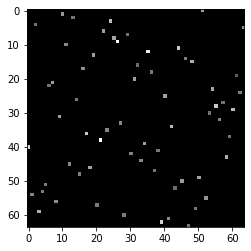

In [65]:
fig, ax = plt.subplots()
im = ax.imshow(C0*gamma)
plt.show()

# or we can access it through al_model.gamma.numpy()

In [67]:
preds_train =  target_model.predict(X_train)[0]
preds_train = (preds_train > 0.5).astype(np.uint8)

In [70]:
# Threshold predictions
print('IoU Train',metric.binary.jc(preds_train,Y_train))
print('Dice Train',metric.binary.dc(preds_train,Y_train))
# print('HD Train',metric.binary.hd(preds_train,Y_train))
# print('ASD Train',metric.binary.assd(preds_train,Y_train))
print('P Train',metric.binary.precision(preds_train,Y_train))
print('R Train',metric.binary.recall(preds_train,Y_train))

IoU Train 0.6017903856035235
Dice Train 0.7513971753261343
P Train 0.7631333364860003
R Train 0.7400165255890016


In [ ]:
# we notice a drop in the Source Domain Performance, hence there is always a trade-off to be done.
# None of the previous method had consider this setting, they only validate over the target domain.


# Further Analysis

In [57]:
preds_test =  target_model.predict(X_test[2909:])[0]
preds_test = (preds_test > 0.5).astype(np.uint8)

In [58]:
print('IoU Test',metric.binary.jc(preds_test,Y_test[2909:]))
print('Dice Test',metric.binary.dc(preds_test,Y_test[2909:]))

IoU Test 0.9302807454383307
Dice Test 0.9638812878766827


# Get Gamma and Cost Matrix for a batch of Data

In [61]:

    indicies= range(0, 64)
    indicies2= range(2909, 2909+64)
    xs_batch=X_train[indicies]#mri
    ys = Y_train[indicies]
    xt_batch = X_test[indicies2] # ct
    ysT  = Y_test[indicies2]
    
    # dummy target outputs for the keras model
    l_dummy = np.zeros_like(ys)  # for target samples
    # for intermediate layer feature values in the target model
    fe_size=vae_encoder_output.shape[1]
    g_dummy = np.zeros((2*batch_size_half, fe_size)) 
    #g_dummyDF = np.zeros((2*batch_size_half, 16384)) 
    ##print('Intermediate Feature Values for Source-Target Batches Shape', g_dummy.shape)
    
    s = xs_batch.shape
            
    # concat of source and target samples and prediction
    modelpred = target_model.predict(np.vstack((xs_batch, xt_batch))) # list of 2, one for output and one for intermediate layer

    
     # modelpred[0] - is softmax prob, and modelpred[1] - is intermediate layer
    gs_batch = modelpred[1][:batch_size_half, :]
    gt_batch = modelpred[1][batch_size_half:, :]
    
    #---------------------------------------------OT Computation-------------------------------------------#
    # distance computation between source and target in deep layer
    C0 = cdist(gs_batch.reshape(batch_size_half,fe_size), 
               gt_batch.reshape(batch_size_half,fe_size),
               metric='sqeuclidean')
    
    # JDOT optimal coupling (gamma)
    gamma=ot.emd(ot.unif(gs_batch.shape[0]),ot.unif(gt_batch.shape[0]),C0)
   

In [63]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import seaborn as sns

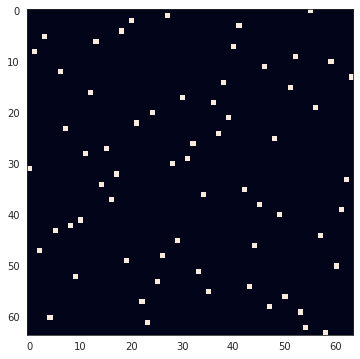

In [64]:
sns.set_style("white")

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)


xx = range(0,1200)
ax.imshow(gamma)


# plt.xlabel('Iterations')
# plt.ylabel('Dice Similarity Coefficient')
# plt.title('Recall')

chartBox = ax.get_position()

#ax.set_position([2*chartBox.x0, 0.5*chartBox.y0, 1.5*chartBox.width, 1.5*chartBox.height])
#ax.legend(loc='upper center', bbox_to_anchor=(1.0, 1.0), shadow=False, ncol=2)

fig1 = plt.gcf()

plt.show()

save_path = '/tf/2021Work/WSC/FiguresPaper/'

# fig1.savefig(save_path +'Gamma3.png', dpi=200,bbox_inches ='tight')    


